In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import os, sys, time, datetime, random, cv2, warnings
warnings.filterwarnings("ignore")


In [10]:
## import the data
train_path = "../data_reconnaissance/train"
test_path = "../data_reconnaissance/test"

## chargemnt des données

## les données de train et de validation
train_dataset = image_dataset_from_directory(
	train_path,
	image_size=(48, 48),
	batch_size = 32
 
)
val_dataset= image_dataset_from_directory(
	train_path,
	image_size=(48, 48),
	batch_size = 32
)
## les dnnées de test
test_dataset = image_dataset_from_directory(
	test_path,
	image_size=(48, 48),
	batch_size = 32
)

classes_names = train_dataset.class_names
print(classes_names)

Found 28709 files belonging to 7 classes.
Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


  Using cached matplotlib-3.10.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (323 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.

2025-02-26 06:43:08.307455: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


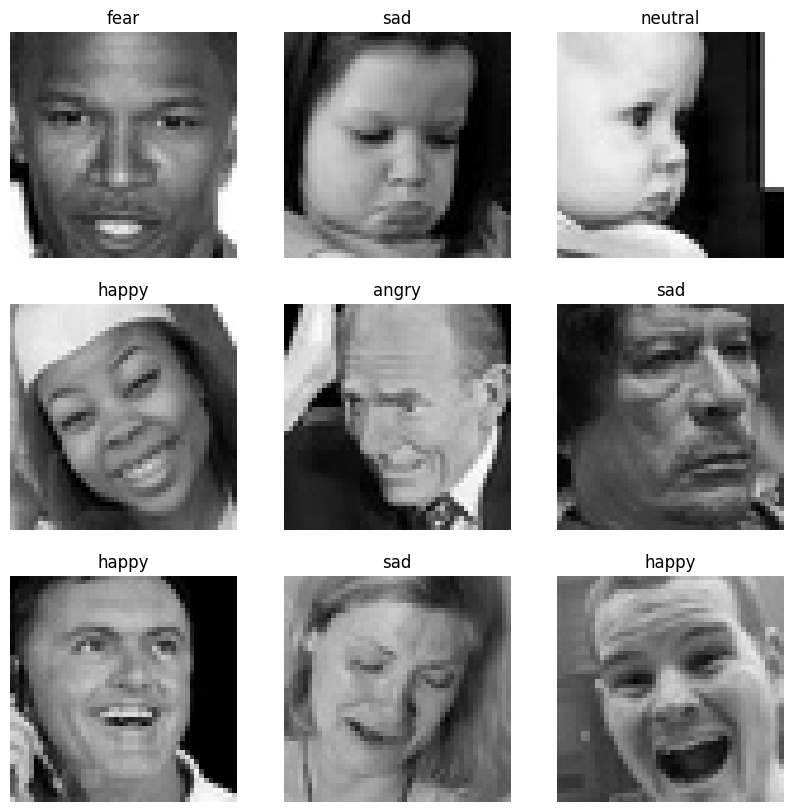

In [11]:
%pip install matplotlib seaborn
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
	for i in range(9):
		ax = plt.subplot(3, 3, i + 1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(classes_names[labels[i]])
		plt.axis("off")

plt.show()

In [12]:
# data prefecting
for batch_data, labels_batch in train_dataset:
	print(f"The shape of batch data is : {batch_data.shape}")
	print(f"The labels of shape is : {labels_batch.shape}")
	break	

The shape of batch data is : (32, 48, 48, 3)
The labels of shape is : (32,)


2025-02-26 06:50:59.364921: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


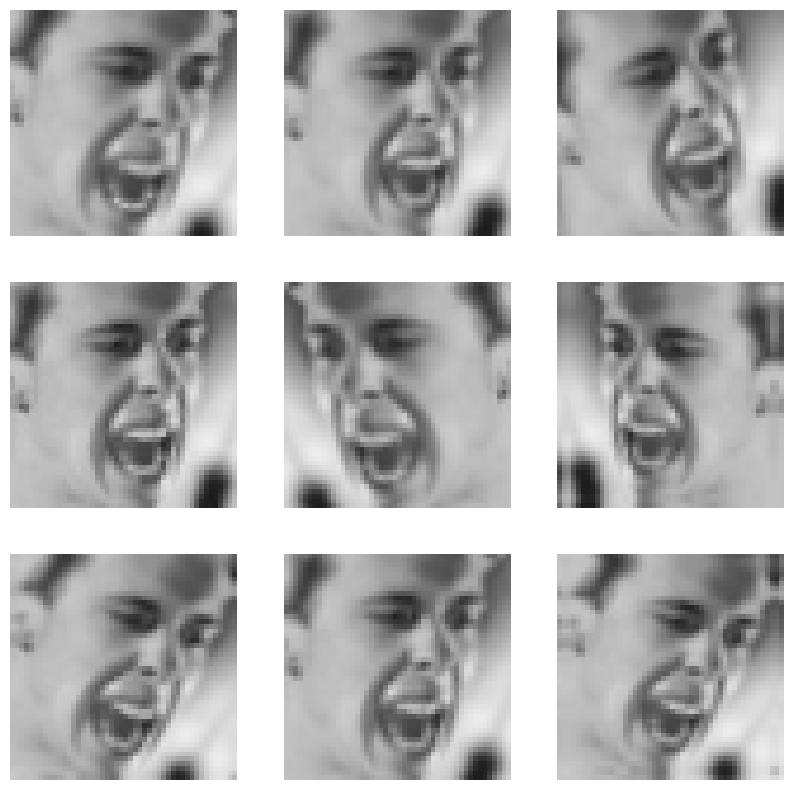

In [15]:
## using data augmentation
data_augmentation = keras.Sequential(
    [
    layers.RandomFlip("horizontal", name="flip_horizontal"),
    layers.RandomRotation(0.1, name="random_rotation"),
    layers.RandomZoom(0.1, name = "random_zoom"),
	]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
	for i in range(9):
		augmented_images = data_augmentation(images)
		ax = plt.subplot(3, 3, i + 1)
		plt.imshow(augmented_images[0].numpy().astype("uint8"))
		plt.axis("off")
plt.show()

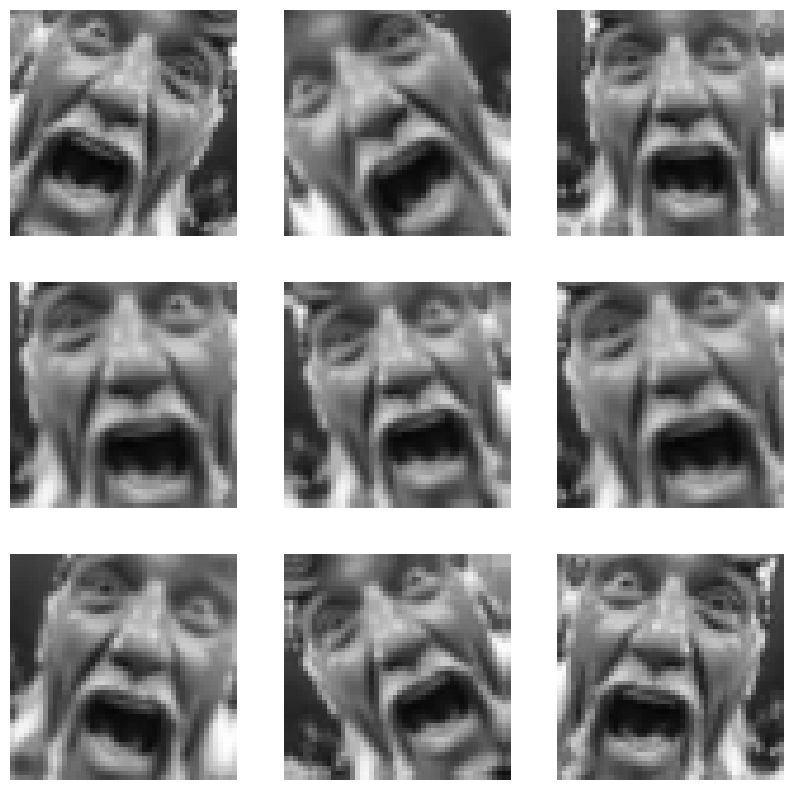

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in val_dataset.take(1):
	for i in range(9):
		augmented_images = data_augmentation(images)
		ax = plt.subplot(3, 3, i + 1)
		plt.imshow(augmented_images[0].numpy().astype("uint8"))
		plt.axis("off")
plt.show()

## First model

In [17]:
inputs = Input(shape=(48, 48, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)
# first conv block
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
# couche de maxpooling
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# second conv block
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
# couche de maxpooling
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# third conv block
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
# couche de maxpooling
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# four conv block
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# flatten the output
x = layers.Flatten()(x)
# first dense layer
x = layers.Dense(128, activation="relu")(x)
# dropout layer
x = layers.Dropout(0.5)(x)
# second dense layer
outputs = layers.Dense(7, activation="softmax")(x)
model = Model(inputs, outputs)

model.compile(
	optimizer=Adam(learning_rate=0.001),
	loss="sparse_categorical_crossentropy",
	metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,215 (1.61 MB)

 Trainable params: 422,215 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## using callbachks
callbacks = [
	keras.callbacks.ModelCheckpoint("first_model.h5",
    save_best_only=True,
    monitor="val_loss"
	),
	keras.callbacks.EarlyStopping(
	monitor="val_loss",
	patience=3,
	verbose=1
	)
]

history = model.fit(
	train_dataset,
	validation_data=val_dataset,
	epochs=50,
	callbacks=callbacks
)


Epoch 1/50


2025-02-26 07:08:11.347392: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.


  1/898 ━━━━━━━━━━━━━━━━━━━━ 3:10:42 13s/step - accuracy: 0.2500 - loss: 1.9318

2025-02-26 07:08:12.257027: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.


  2/898 ━━━━━━━━━━━━━━━━━━━━ 14:49 993ms/step - accuracy: 0.2266 - loss: 1.9340

2025-02-26 07:08:13.423717: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.


  3/898 ━━━━━━━━━━━━━━━━━━━━ 14:15 956ms/step - accuracy: 0.2344 - loss: 1.9261

2025-02-26 07:08:13.987069: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.


  5/898 ━━━━━━━━━━━━━━━━━━━━ 11:53 799ms/step - accuracy: 0.2272 - loss: 1.9250

2025-02-26 07:08:14.751719: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23369472 exceeds 10% of free system memory.


897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.2412 - loss: 1.8226

898/898 ━━━━━━━━━━━━━━━━━━━━ 369s 397ms/step - accuracy: 0.2412 - loss: 1.8225 - val_accuracy: 0.3150 - val_loss: 1.6900
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.3088 - loss: 1.7084

898/898 ━━━━━━━━━━━━━━━━━━━━ 371s 414ms/step - accuracy: 0.3088 - loss: 1.7084 - val_accuracy: 0.3943 - val_loss: 1.5390
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.3784 - loss: 1.5935

898/898 ━━━━━━━━━━━━━━━━━━━━ 591s 659ms/step - accuracy: 0.3784 - loss: 1.5934 - val_accuracy: 0.4392 - val_loss: 1.4449
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.4169 - loss: 1.5054

898/898 ━━━━━━━━━━━━━━━━━━━━ 593s 661ms/step - accuracy: 0.4169 - loss: 1.5054 - val_accuracy: 0.4624 - val_loss: 1.3861
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 601s 670ms/step - accuracy: 0.4451 - loss: 1.4473 - val_accuracy: 0.4696 - val_loss: 1.3925
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4618 - loss: 1.4097

898/898 ━━━━━━━━━━━━━━━━━━━━ 234s 261ms/step - accuracy: 0.4618 - loss: 1.4097 - val_accuracy: 0.5042 - val_loss: 1.3031
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 274s 305ms/step - accuracy: 0.4719 - loss: 1.3816 - val_accuracy: 0.4966 - val_loss: 1.3086
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4825 - loss: 1.3558

898/898 ━━━━━━━━━━━━━━━━━━━━ 232s 259ms/step - accuracy: 0.4825 - loss: 1.3558 - val_accuracy: 0.5327 - val_loss: 1.2308
Epoch 9/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.4882 - loss: 1.3397

898/898 ━━━━━━━━━━━━━━━━━━━━ 227s 252ms/step - accuracy: 0.4883 - loss: 1.3396 - val_accuracy: 0.5396 - val_loss: 1.2056
Epoch 10/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 231s 257ms/step - accuracy: 0.4998 - loss: 1.3141 - val_accuracy: 0.5271 - val_loss: 1.2372
Epoch 11/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 263s 258ms/step - accuracy: 0.5052 - loss: 1.3072 - val_accuracy: 0.5349 - val_loss: 1.2185
Epoch 12/50
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5084 - loss: 1.2930

898/898 ━━━━━━━━━━━━━━━━━━━━ 177s 198ms/step - accuracy: 0.5084 - loss: 1.2930 - val_accuracy: 0.5494 - val_loss: 1.1847
Epoch 13/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 219s 244ms/step - accuracy: 0.5146 - loss: 1.2934 - val_accuracy: 0.5263 - val_loss: 1.2644
Epoch 14/50
 93/898 ━━━━━━━━━━━━━━━━━━━━ 5:00 374ms/step - accuracy: 0.4979 - loss: 1.3407